# Variational Autoencoder Galaxy generator

## Import libraries

In [35]:
import os
from glob import glob
from utils.custom_utils import RetrieveData, show_images
import pandas as pd
import random as rd

from PIL import Image
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils

## Download data

In [2]:
DataURL='https://tinyurl.com/mr2yc5nx'

RetrieveData(DataURL)

## dataloader and data verification

In [27]:
image_path='./data/images_gz2/images'

In [28]:
class GalaxyZoo2(Dataset):
	def __init__(self, img_dir, transform=None, train=True):
		self.transform = transform
		self.img_dir = img_dir
		
		images=glob(os.path.join(img_dir,'*.jpg'))
		rd.shuffle(images)
		
		cut=int(0.6*len(images))
		if train:
			self.images=images[:cut]
		else:
			self.images=images[cut:]
		
	def __len__(self):
		return len(self.images)
	
	def __getitem__(self, index):
		img_to_tensor=transforms.Compose([transforms.PILToTensor()])
		img_path=self.images[index]
		with Image.open(img_path) as im:
			im=img_to_tensor(im)
			if self.transform:
				im = self.transform(im)
			return im

In [29]:
trainset=GalaxyZoo2(image_path)

In [30]:
trainloader=DataLoader(trainset, batch_size=4, shuffle=True, num_workers=2)

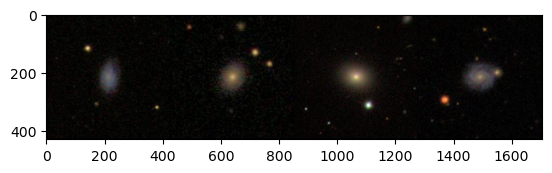

In [31]:
images=next(iter(trainloader))
show_images(utils.make_grid(images))

## VAE

In [ ]:
class MLP_VAE(nn.Module):
    def __init__(self,img_dim,latent_dim,mlp_outlayers=256,intermediate_dim=128):
        super().__init__()
        
        self.encoder = nn.Sequential(nn.Linear(img_dim, mlp_outlayers),
                                     nn.ReLU(),
                                     nn.Linear(mlp_outlayers, intermediate_dim))
        
        self.mu     = nn.Linear(intermediate_dim, latent_dim)
        self.logvar = nn.Linear(intermediate_dim, latent_dim)
        
        self.latent_mapping = nn.Linear(latent_dim, intermediate_dim)
        
        self.decoder = nn.Sequential(nn.Linear(intermediate_dim, mlp_outlayers),
                                     nn.ReLU(),
                                     nn.Linear(mlp_outlayers, img_dim))
        
        
    def encode(self, x):
        x = x.view(x.size(0), -1)
        encoder = self.encoder(x)
        mu, logvar = self.mu(encoder), self.logvar(encoder)
        return mu, logvar
        
    def sample_z(self, mu, logvar):
        eps = torch.rand_like(mu)
        return mu + eps * torch.exp(0.5 * logvar)
    
    def decode(self, z,x):
        latent_z = self.latent_mapping(z)
        out = self.decoder(latent_z)
        reshaped_out = torch.sigmoid(out).view(x.shape[0],1, 28,28)
        return reshaped_out
        
    def forward(self, x):
        
        mu, logvar = self.encode(x)
        z = self.sample_z(mu, logvar)
        output = self.decode(z,x)
        
        return output